In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/Study/Видобування/FW_PG_Meteo_2018-2019.csv' /content/dataset.csv

clear_output()

In [0]:
dataset = pd.read_csv('/content/dataset.csv')

In [0]:
dataset.head()

,Year,Month,Day,Hour,Minute,Second,FW_PG,Wind_Speed,Wind_Direction,Temperature,Relative_Humidity,Pressure,Precipitation,DewPoint,Absolute_Humidity,Specific_Humidity
0,2018,1,1,0,0,0,106.772863,0.24,8.93,2.69,89.67,1011.00,0.0,1.149374,5.223580,0.804220
1,2018,1,1,0,1,0,105.187933,0.29,8.90,2.74,90.25,1011.01,0.0,1.288370,5.275076,0.805798
2,2018,1,1,0,2,0,119.689349,0.10,8.11,2.60,90.11,1011.00,0.0,1.128684,5.217515,0.803984
3,2018,1,1,0,3,0,106.389584,0.08,2.92,2.52,90.35,1010.99,0.0,1.086740,5.203304,0.803505
4,2018,1,1,0,4,0,106.443489,0.08,349.30,2.57,90.75,1010.98,0.0,1.197495,5.243970,0.804768


In [0]:
dataset.info()

## об'єднати часову мітку

In [0]:
dataset['Date'] = pd.to_datetime(dataset[["Year", "Month", "Day", "Hour", "Minute", "Second"]])
dataset.set_index('Date', inplace=True)
dataset.drop(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'], axis=1, inplace=True)
dataset.head()

,FW_PG,Wind_Speed,Wind_Direction,Temperature,Relative_Humidity,Pressure,Precipitation,DewPoint,Absolute_Humidity,Specific_Humidity
Date,,,,,,,,,,
2018-01-01 00:00:00,106.772863,0.24,8.93,2.69,89.67,1011.00,0.0,1.149374,5.223580,0.804220
2018-01-01 00:01:00,105.187933,0.29,8.90,2.74,90.25,1011.01,0.0,1.288370,5.275076,0.805798
2018-01-01 00:02:00,119.689349,0.10,8.11,2.60,90.11,1011.00,0.0,1.128684,5.217515,0.803984
2018-01-01 00:03:00,106.389584,0.08,2.92,2.52,90.35,1010.99,0.0,1.086740,5.203304,0.803505
2018-01-01 00:04:00,106.443489,0.08,349.30,2.57,90.75,1010.98,0.0,1.197495,5.243970,0.804768


## пошук NaN

In [0]:
print(dataset.isna().sum())

FW_PG                301018
Wind_Speed           156904
Wind_Direction       160913
Temperature          156907
Relative_Humidity    157008
Pressure             156902
Precipitation        135831
DewPoint             157550
Absolute_Humidity    157550
Specific_Humidity    157550
dtype: int64


In [0]:
dataset[dataset.iloc[:,1:].isnull().values]

In [0]:
dataset.dropna(thresh=2, inplace=True)

In [0]:
print(dataset.isna().sum())

In [0]:
dataset['FW_PG'].fillna(dataset['FW_PG'].mean(), inplace=True)

In [0]:
dataset['FW_PG'].isna().sum()

In [0]:
dataset['Wind_Speed'].fillna(dataset['Wind_Speed'].mean(), inplace=True)
dataset['Wind_Direction'].fillna(dataset['Wind_Direction'].mean(), inplace=True)
dataset['Temperature'].fillna(dataset['Temperature'].mean(), inplace=True)
dataset['Relative_Humidity'].fillna(dataset['Relative_Humidity'].mean(), inplace=True)
dataset['Pressure'].fillna(dataset['Pressure'].mean(), inplace=True)
dataset['Precipitation'].fillna(dataset['Precipitation'].mean(), inplace=True)
dataset['DewPoint'].fillna(dataset['DewPoint'].mean(), inplace=True)
dataset['Absolute_Humidity'].fillna(dataset['Absolute_Humidity'].mean(), inplace=True)
dataset['Specific_Humidity'].fillna(dataset['Specific_Humidity'].mean(), inplace=True)

In [0]:
dataset.isna().sum()

FW_PG                0
Wind_Speed           0
Wind_Direction       0
Temperature          0
Relative_Humidity    0
Pressure             0
Precipitation        0
DewPoint             0
Absolute_Humidity    0
Specific_Humidity    0
dtype: int64

In [0]:
dataset['Precipitation'].unique()

array([0.])

In [0]:
dataset.drop(['Precipitation'], axis=1, inplace=True)

In [0]:
dataset.info()

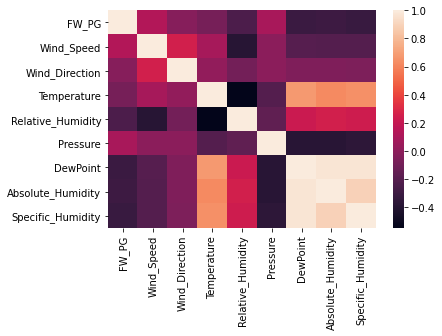

In [0]:
corr = dataset.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [0]:
dataset.drop(['Absolute_Humidity', 'Specific_Humidity'], axis=1, inplace=True)

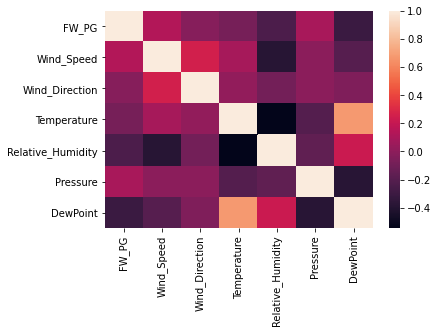

In [0]:
corr = dataset.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [0]:
dataset['FW_PG'].resample('1T').mean().autocorr(lag=1)

0.9562621051588415

In [0]:
from matplotlib import pyplot
values = dataset.values
i = 1
pyplot.figure(figsize=(20,20))
for group in range(len(dataset.columns)):
	pyplot.subplot(len(dataset.columns), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
dataset.to_csv('data.csv')

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, explained_variance_score

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
data = pd.read_csv('data.csv', header=0, index_col=0)
values = data.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.305074,0.018319,0.024806,0.157437,0.881577,0.788512,0.459598,0.300546
2,0.300546,0.023707,0.024722,0.158646,0.888227,0.788652,0.462830,0.341979
3,0.341979,0.003233,0.022528,0.155260,0.886622,0.788512,0.459117,0.303979
4,0.303979,0.001078,0.008111,0.153325,0.889373,0.788371,0.458142,0.304133
5,0.304133,0.001078,0.970278,0.154534,0.893959,0.788231,0.460717,0.324146


In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(525600, 1, 7) (525600,) (386249, 1, 7) (386249,)


### train RNN

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from math import sqrt
from numpy import concatenate
# make a prediction
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
acc = explained_variance_score(inv_y, inv_yhat)
print(f'Test RMSE: {rmse:.3f}')
print(f'Acc: {acc:.3f}')

Test RMSE: 17.730
Acc: 0.927
